In [26]:
import gspread as gs
import pandas as pd
import json
import matplotlib.pyplot as plt
import time
import datetime
import matplotlib.ticker as ticker


In [ ]:
# Service-account.json file is present in shared drive. To generate your own file follow steps online to create
# google-sheets api key.

In [27]:
gc = gs.service_account(filename='service-account.json')
url = "https://docs.google.com/spreadsheets/d/1I6SsB7PkomcsnYIOeSiilzNwMmZLUe1jmSSK3XWcXD4/edit?resourcekey#gid=2118111024"
sh = gc.open_by_url(url)
ws = sh.worksheet('responses')

In [28]:
df = pd.DataFrame(ws.get_all_records())
df = df[(df['Level'] != 'ButtonMovingTrapScene')]
df.head()

,Timestamp,PlayerName,Level,PlayerDeaths,CloneDeaths,SessionID,LevelTime,Restarts
0,9/30/2022 12:49:07,TestUser,0-1,0,0,6.380010e+17,7.89,1
1,9/30/2022 12:49:20,TestUser,0-2,0,2,6.380010e+17,12.66,0
2,9/30/2022 12:49:36,TestUser,0-3,0,3,6.380010e+17,16.55,1
3,9/30/2022 12:51:47,TestUser,0-1,0,0,6.380010e+17,3.89,1
4,9/30/2022 12:51:52,TestUser,0-2,0,1,6.380010e+17,5.10,0


## Date time Filter

In [29]:
beginDate = input("Enter beginning date (mm/dd/yyyy)")
endDate = input("Enter ending date (mm/dd/yyyy)")

Enter beginning date (mm/dd/yyyy)10/10/2022
Enter ending date (mm/dd/yyyy)10/12/2022


In [30]:
beginDate = beginDate + ' 00:00:00'
endDate = endDate + ' 23:59:59'

print(beginDate)
print(endDate)

10/10/2022 00:00:00
10/12/2022 23:59:59


In [31]:
dateFormatting = lambda x : datetime.datetime.strptime(x, format_data)

In [32]:
format_data = "%m/%d/%Y %H:%M:%S"

beginDate = dateFormatting(beginDate)
endDate = dateFormatting(endDate)

df['Timestamp'] = df['Timestamp'].apply(dateFormatting)

df = df[(df['Timestamp'] >= beginDate) & (df['Timestamp'] <= endDate)]
df = df.dropna()

### Validation 

In [33]:
if df.isnull().values.any():
    print("Error!: Null values present")
    
invalid = df[(df['PlayerDeaths'] == 1) & (df['Restarts'] == 1)]
if len(invalid) != 0:
    print("Error!: Invalid entry present")

# Average Player and Clone Deaths per Level

<AxesSubplot: xlabel='Level'>

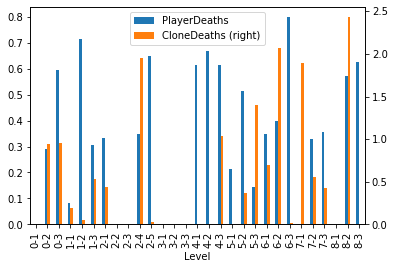

In [34]:
# Average player and clone deaths per level
deathsAvgLevel=df.groupby(by=["Level"]).aggregate({"PlayerDeaths":"mean", "CloneDeaths":"mean"})
deathsAvgLeveldf = deathsAvgLevel.reset_index()

# deathsAvgLeveldf.plot(x = 'level', y = 'playerDeaths', kind = 'barh')
deathsAvgLeveldf.plot(x = 'Level', secondary_y = 'CloneDeaths', kind = 'bar')

# Average Time taken per level

<AxesSubplot: ylabel='Level'>

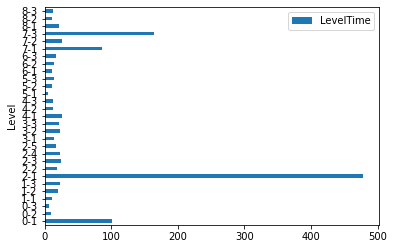

In [35]:
# Average player deaths per level
levelTimeAvgLevel=df.groupby(by=["Level"]).aggregate({"LevelTime":"mean"})
levelTimeAvgLeveldf = levelTimeAvgLevel.reset_index()

levelTimeAvgLeveldf.plot(x = 'Level', y = 'LevelTime', kind = 'barh')

# Unique player attempts vs success rate per level

<AxesSubplot: xlabel='Level', ylabel='Number of Unique Players'>

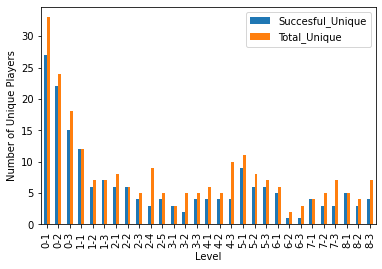

In [36]:
successAttempts = df[(df['PlayerDeaths'] == 0) & (df['Restarts'] == 0)]
failAttempts = df[(df['PlayerDeaths'] != 0) | (df['Restarts'] != 0)]
df1 = successAttempts.groupby(['Level']).aggregate({"SessionID": lambda x: x.nunique()}).reset_index()
df2 = df.groupby(['Level']).aggregate({"SessionID": lambda x: x.nunique()}).reset_index()
df3 = pd.merge(df1, df2, on='Level')
df3.columns = ['Level', 'Succesful_Unique', 'Total_Unique']
df3["Percentage_Succes"] = (df3['Succesful_Unique'] / df3['Total_Unique']) * 100
df3['Percentage_Succes'] = df3['Percentage_Succes'].apply(lambda x: float("{:.2f}".format(x)))
df3.plot(x = 'Level', y = ['Succesful_Unique', 'Total_Unique'], ylabel = "Number of Unique Players", kind = 'bar')

<AxesSubplot: xlabel='Level', ylabel='Percentage of Succesful Completion'>

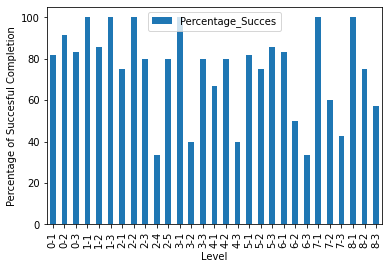

In [37]:
df3.plot(x = 'Level', y = 'Percentage_Succes', ylabel = "Percentage of Succesful Completion", kind = 'bar')

# Time per attempt of every level

Text(0.5, 0, 'Levels')

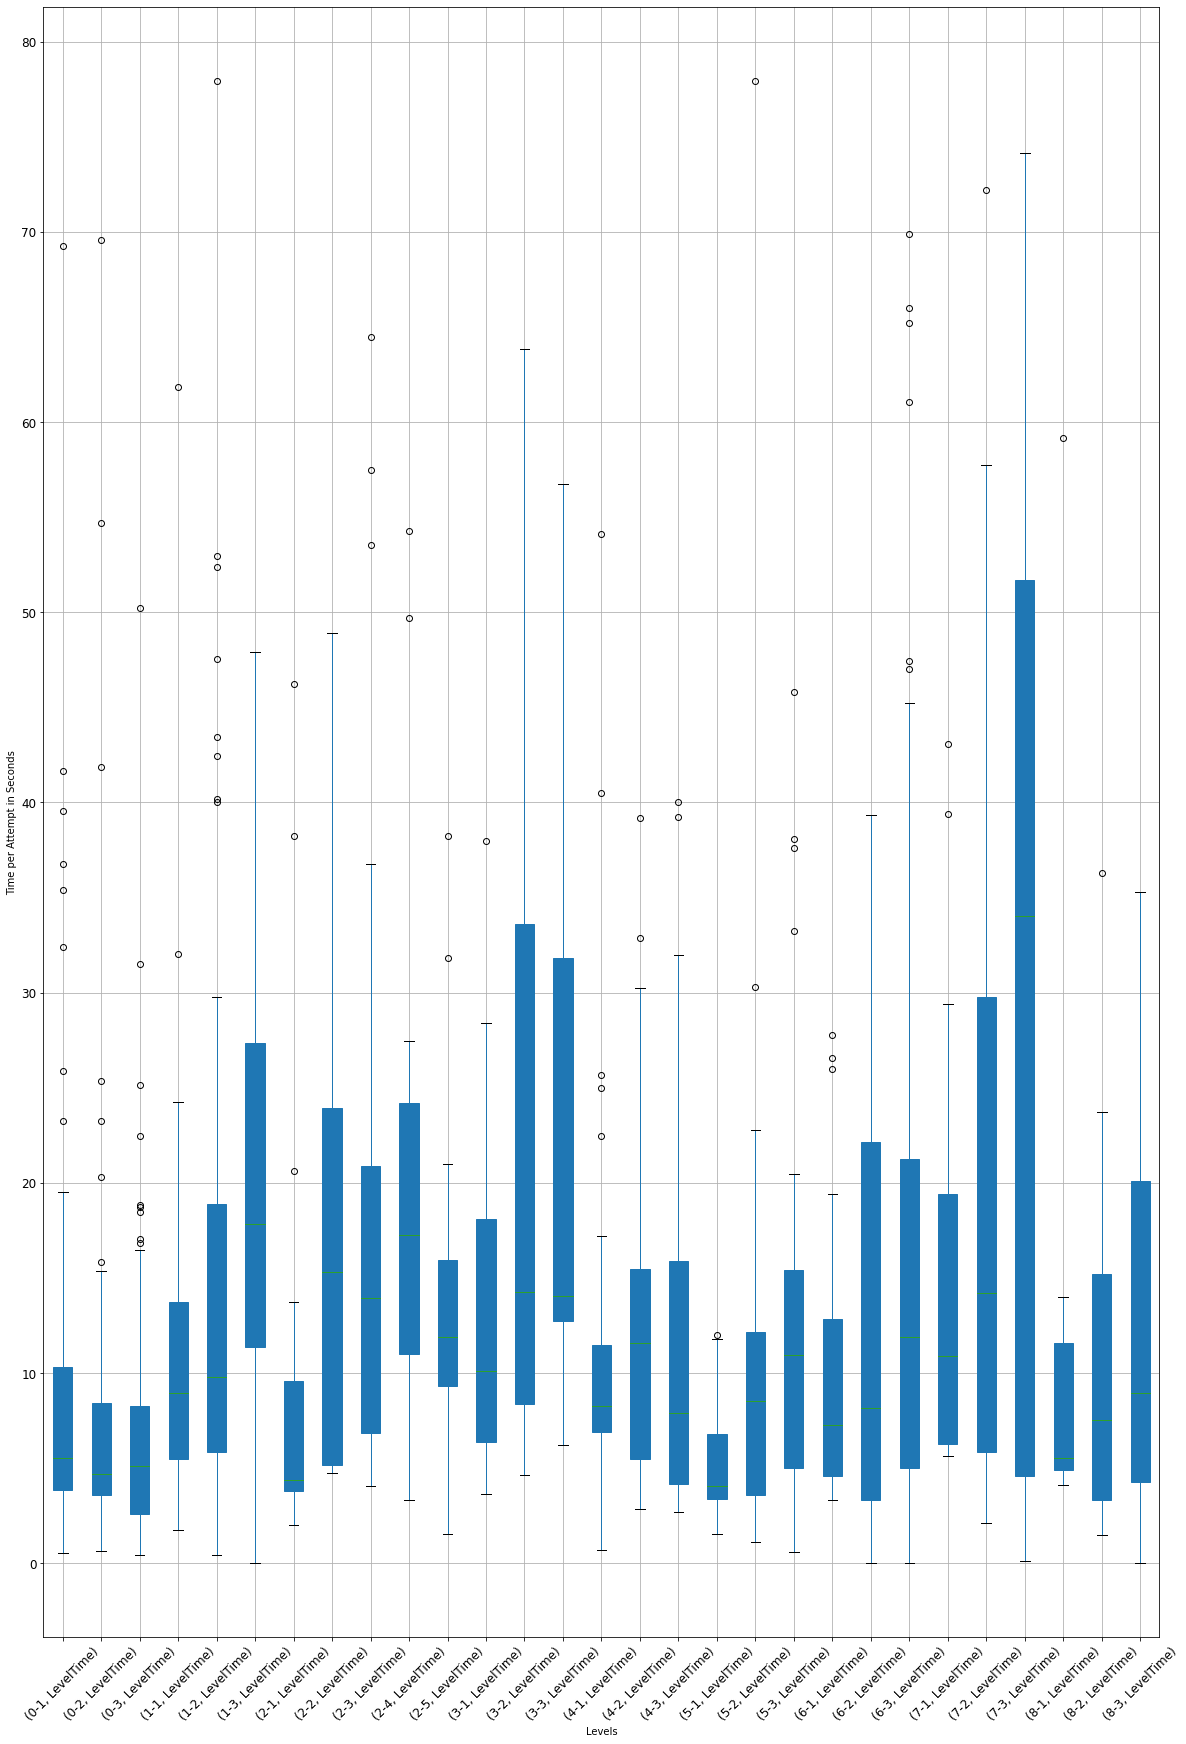

In [38]:
timedf = df[df['LevelTime']<=80]
bplot = timedf.groupby("Level").boxplot(column = "LevelTime", rot=45, fontsize=12, figsize=(20,30), subplots = "False", patch_artist=True)
bplot.set_ylabel('Time per Attempt in Seconds')
bplot.set_xlabel('Levels')

# Average Attempts per level

<AxesSubplot: xlabel='Level', ylabel='Attempts'>

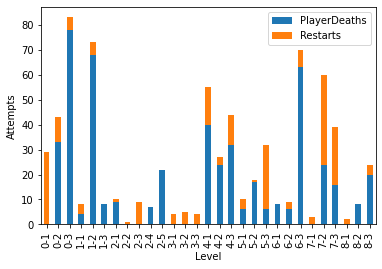

In [39]:
tick_spacing = 1

playerAttemptsAvgLevel=df.groupby(by=["Level"]).aggregate({"PlayerDeaths":"sum", "Restarts":"sum"})
# playerAttemptsAvgLevel
playerAttemptsAvgLevel = playerAttemptsAvgLevel.reset_index()
playerAttemptsAvgLevel.plot.bar(x='Level', ylabel = "Attempts", stacked=True)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# Average Clone Deaths vs success per Level

<AxesSubplot: xlabel='Level', ylabel='Avg Clone Deaths'>

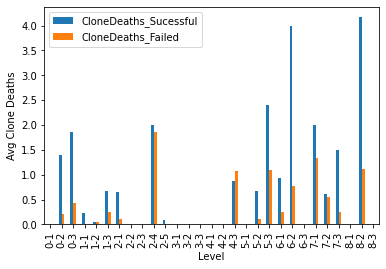

In [40]:
cloneAttemptsSuccessful=successAttempts.groupby(by=["Level"]).aggregate({"CloneDeaths":"mean"})
cloneAttemptsSuccessful = cloneAttemptsSuccessful.reset_index()
cloneAttemptsSuccessful
cloneAttemptsFailure = failAttempts.groupby(by=["Level"]).aggregate({"CloneDeaths":"mean"})
cloneAttemptsFailure = cloneAttemptsFailure.reset_index()
cloneAttemptsFailure

cloneStats = pd.merge(cloneAttemptsSuccessful, cloneAttemptsFailure, on='Level')
cloneStats.columns = ['Level', 'CloneDeaths_Sucessful', 'CloneDeaths_Failed']
cloneStats.plot(x = 'Level', ylabel = "Avg Clone Deaths", y = ['CloneDeaths_Sucessful', 'CloneDeaths_Failed'], kind = 'bar')
